In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pathlib 
import sys
from tqdm import tqdm

sys.path.append("..")
from utils.utils import show_mask_image

from  utils.sample_patches_main import sample_patches, sample_hard_negatives, sample_blob_negatives


In [3]:
annotations = pd.read_json('../resources/ddsm/ddsm_annotations_16bits_1152_896.json.gz', orient='records', lines=True, compression='gzip')
annotations = pd.read_json('../resources/ddsm/ddsm_annotations_16bits_2400_1792.json.gz', orient='records', lines=True, compression='gzip')

print(len(annotations)) # coincide con el número de máscaras
split_csv = '../resources/ddsm/DDSM_test.csv'
split_csv = '../resources/ddsm/ddsm_nikulin_partitions/test_filenames.txt'

print("Num images in test split: ", len(pd.read_csv(split_csv)))
test_images = pd.read_csv(split_csv)
print("num test images: ", len(test_images))

#test_images = test_images.ddsm_image.values


4664
Num images in test split:  986
num test images:  986


In [4]:
print(annotations)

               type  assessment  subtlety  pathology  \
0              MASS           3         3  MALIGNANT   
1              MASS           3         3  MALIGNANT   
2     CALCIFICATION           0         4  MALIGNANT   
3     CALCIFICATION           3         2  MALIGNANT   
4              MASS           4         4  MALIGNANT   
...             ...         ...       ...        ...   
4659  CALCIFICATION           4         4     BENIGN   
4660           MASS           4         2     BENIGN   
4661           MASS           4         2     BENIGN   
4662           MASS           5         5     BENIGN   
4663           MASS           5         5     BENIGN   

                                                outline  \
0     [[1586.6772546795, 1586.6772546795, 1586.16903...   
1     [[1623.8357771261, 1623.8357771261, 1623.35803...   
2     [[1806.4734982332, 1806.4734982332, 1805.56890...   
3     [[1773.6299333675, 1773.6299333675, 1772.71143...   
4     [[530.92714517, 530.927145

In this sample the boundary is beyond the image limits

max points:  [1806.47349823 1133.67832747]


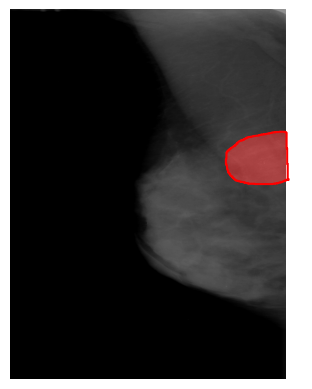

In [7]:
annotation = annotations.iloc[2]
ddsm_root_dir = pathlib.Path('/home/alalbiol/Data/mamo/DDSM_png_1152x896')
ddsm_root_dir = pathlib.Path('/home/alalbiol/Data/mamo/DDSM_png_16bit_2400x1792')


image_id = annotation['image_id']
image_path = ddsm_root_dir / image_id
img = np.array(Image.open(str(image_path)))

mask_id = annotation['mask_id']
roi_mask_path = ddsm_root_dir / mask_id
roi_mask = np.array(Image.open(str(roi_mask_path)))

points = np.array(annotation['outline']).T

show_mask_image(img, roi_mask)
plt.plot(points[:,0], points[:,1], 'r-')

print("max points: ", np.max(points, axis=0))
# hay anotaciones que se salen de la imagen hay que tener cuidado con eso




In [8]:
    


def extract_patches_from_anot(annotation, test_images, out_dir,  ddsm_root_dir, nb_abn = 2, nb_bkg = 1, 
                            patch_size=512, verbose=False, standarize_img=True):
    ddsm_root_dir = pathlib.Path(ddsm_root_dir)
    
    image_id = annotation['image_id']
    
    
    
    
    if image_id not in test_images:
        return
    
   
    image_path = ddsm_root_dir / image_id
    img = np.array(Image.open(str(image_path)))
    
    mask_id = annotation['mask_id']
    roi_mask_path = ddsm_root_dir / mask_id
    roi_mask = np.array(Image.open(str(roi_mask_path)))
    
    points = np.array(annotation['outline']).T
    
    xmin, ymin = points.min(axis=0)
    xmax, ymax = points.max(axis=0)
    xmin = max(xmin, 0)
    ymin = max(ymin, 0)
    xmax = min(xmax, img.shape[1]-1)
    ymax = min(ymax, img.shape[0]-1)
    
    width = xmax - xmin
    height = ymax - ymin
    bounding_box = (xmin, ymin, width, height)
    
    assert xmin >= 0, image_id
    assert ymin >= 0 , image_id
    assert xmax < img.shape[1], f"{xmax} < {img.shape[1]}"
    assert ymax < img.shape[0]
    assert width > 0, f"{image_id} {width} {xmin} {xmax}"
    assert height > 0, image_id
    

    
    sample_patches(img, roi_mask, out_dir, mask_id, bounding_box, patch_size=patch_size,
                pos_cutoff=.9, neg_cutoff=.1,
                nb_bkg=nb_bkg, nb_abn=nb_abn,
                verbose=verbose, standarize_img=standarize_img)
    



Extract patches from one annotation

In [13]:


root_ddsm = '/home/alalbiol/Data/mamo/DDSM_png_16bit_1152x896'
root_ddsm = '/home/alalbiol/Data/mamo/DDSM_png_16bit_2400x1792'

patch_size = 448
out_dir = pathlib.Path(f'/tmp/ex_patches/')
out_dir.mkdir(exist_ok=True)

test_images =  annotations.image_id.unique() # all images here
nrow = 4
ncol = 4
num_images = nrow * ncol


extract_patches_from_anot(annotations.iloc[2], test_images, out_dir, root_ddsm, 
                            patch_size=patch_size,
                            nb_abn=8, nb_bkg=8,
                            verbose=True
                            )



D_4161_1.RIGHT_MLO_CALCIFICATION_MALIGNANT_mask_0_0000_mask.png: sampled abn at (1673, 998)
D_4161_1.RIGHT_MLO_CALCIFICATION_MALIGNANT_mask_0_0001_mask.png: sampled abn at (1561, 1060)
D_4161_1.RIGHT_MLO_CALCIFICATION_MALIGNANT_mask_0_0002_mask.png: sampled abn at (1660, 989)
D_4161_1.RIGHT_MLO_CALCIFICATION_MALIGNANT_mask_0_0003_mask.png: sampled abn at (1684, 926)
D_4161_1.RIGHT_MLO_CALCIFICATION_MALIGNANT_mask_0_0004_mask.png: sampled abn at (1598, 941)
D_4161_1.RIGHT_MLO_CALCIFICATION_MALIGNANT_mask_0_0005_mask.png: sampled abn at (1677, 995)
D_4161_1.RIGHT_MLO_CALCIFICATION_MALIGNANT_mask_0_0006_mask.png: sampled abn at (1602, 1002)
D_4161_1.RIGHT_MLO_CALCIFICATION_MALIGNANT_mask_0_0007_mask.png: sampled abn at (1638, 880)
D_4161_1.RIGHT_MLO_CALCIFICATION_MALIGNANT_mask_0_0000_mask.png: sampled a bkg at= (378, 1770)
D_4161_1.RIGHT_MLO_CALCIFICATION_MALIGNANT_mask_0_0001_mask.png: sampled a bkg at= (1687, 125)
D_4161_1.RIGHT_MLO_CALCIFICATION_MALIGNANT_mask_0_0002_mask.png: sampled

Num images:  16
Num images:  16 16


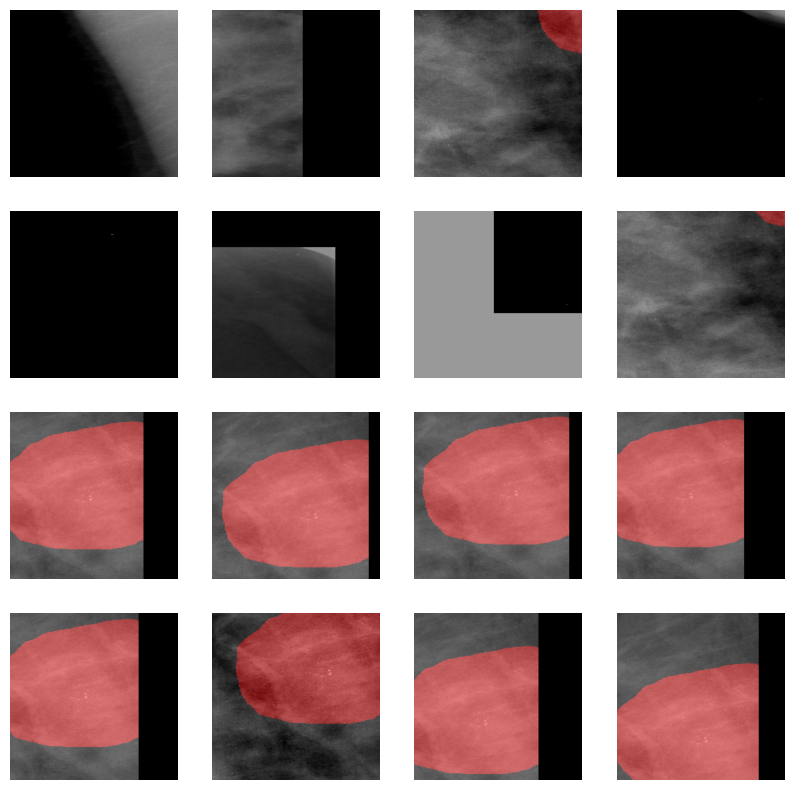

In [14]:


images = list(out_dir.rglob('*img.npy'))

print ("Num images: ", len(images))
#sample 16 images

#images = np.random.choice(images, num_images)
masks = [str(img).replace('_img.npy', '_mask.png') for img in images]
print("Num images: ", len(images), len(masks))

fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(10, 10))
ax = ax.ravel()




for i in range(num_images):
    
    
    
    #img = np.array(Image.open(images[i]))
    img = np.load(images[i])
    
    assert img.shape[0] == img.shape[1] and img.shape[0] == patch_size, f"{img.shape}"
    mask = np.array(Image.open(masks[i]))
    show_mask_image(img, mask, ax[i])


Not extract patches from all the dataset with several sizes

In [9]:
# let's clean the directory
!rm /tmp/eval_patches_* -rf 

In [15]:

test_images = pd.read_csv(split_csv)
test_images = test_images.ddsm_image.values
print("num test images: ", len(test_images))

root_ddsm = '/home/alalbiol/Data/mamo/DDSM_png_16bit_1152x896'
root_ddsm = '/home/alalbiol/Data/mamo/DDSM_png_16bit_2400x1792'

patch_sizes = [448]
for patch_size in patch_sizes:
    print(f"Extractig patches of size {patch_size}")
    out_dir = pathlib.Path(f'/tmp/eval_patches_16bits_{patch_size}_x2_test_nikulin/')
    out_dir.mkdir(exist_ok=True)

    for k in tqdm(range(len(annotations))):
        extract_patches_from_anot(annotations.iloc[k], test_images, out_dir, root_ddsm, 
                                patch_size=patch_size)
    

 

num test images:  986
Extractig patches of size 448


  4%|▍         | 184/4664 [00:19<00:49, 89.75it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.85


  9%|▉         | 418/4664 [00:50<02:37, 27.03it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.85
Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.7999999999999999
Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.7499999999999999


 13%|█▎        | 608/4664 [01:23<01:19, 50.98it/s]  

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.85


 13%|█▎        | 608/4664 [01:40<01:19, 50.98it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.7999999999999999
Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.7499999999999999


 22%|██▏       | 1020/4664 [02:11<00:21, 171.34it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.85


 26%|██▋       | 1225/4664 [02:40<02:34, 22.22it/s] 

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.85
Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.7999999999999999


 28%|██▊       | 1329/4664 [03:20<09:51,  5.64it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.85


 29%|██▊       | 1338/4664 [03:24<19:09,  2.89it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.85


 29%|██▊       | 1338/4664 [03:40<19:09,  2.89it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.85


 29%|██▊       | 1340/4664 [03:53<53:51,  1.03it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.85


 32%|███▏      | 1495/4664 [04:10<05:07, 10.31it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.85


 33%|███▎      | 1557/4664 [04:25<09:22,  5.52it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.85


 35%|███▌      | 1636/4664 [04:43<06:08,  8.23it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.85


 35%|███▌      | 1636/4664 [05:00<06:08,  8.23it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.7999999999999999
Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.7499999999999999
Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.6999999999999998


 35%|███▌      | 1652/4664 [05:42<1:02:11,  1.24s/it]

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.85


 42%|████▏     | 1940/4664 [06:04<03:15, 13.95it/s]  

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.85


 42%|████▏     | 1940/4664 [06:20<03:15, 13.95it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.7999999999999999


 43%|████▎     | 1989/4664 [06:34<18:57,  2.35it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.85
Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.7999999999999999


 45%|████▌     | 2107/4664 [07:20<07:55,  5.38it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.85


 70%|██████▉   | 3263/4664 [07:33<00:22, 62.15it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.85


 70%|██████▉   | 3263/4664 [07:50<00:22, 62.15it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.7999999999999999


 73%|███████▎  | 3415/4664 [08:20<00:53, 23.33it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.85
Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.7999999999999999
Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.7499999999999999


 77%|███████▋  | 3605/4664 [08:52<00:17, 61.49it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.85


 89%|████████▊ | 4136/4664 [09:30<00:12, 41.22it/s] 

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.85


 90%|█████████ | 4210/4664 [09:34<00:29, 15.26it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.85


 90%|█████████ | 4210/4664 [09:50<00:29, 15.26it/s]

Nb of trials reached maximum, decrease overlap cutoff by 0.05: 0.7999999999999999


100%|██████████| 4664/4664 [10:11<00:00,  7.63it/s]


Num images:  16 16


Text(0.5, 0.98, 'Patch size 448')

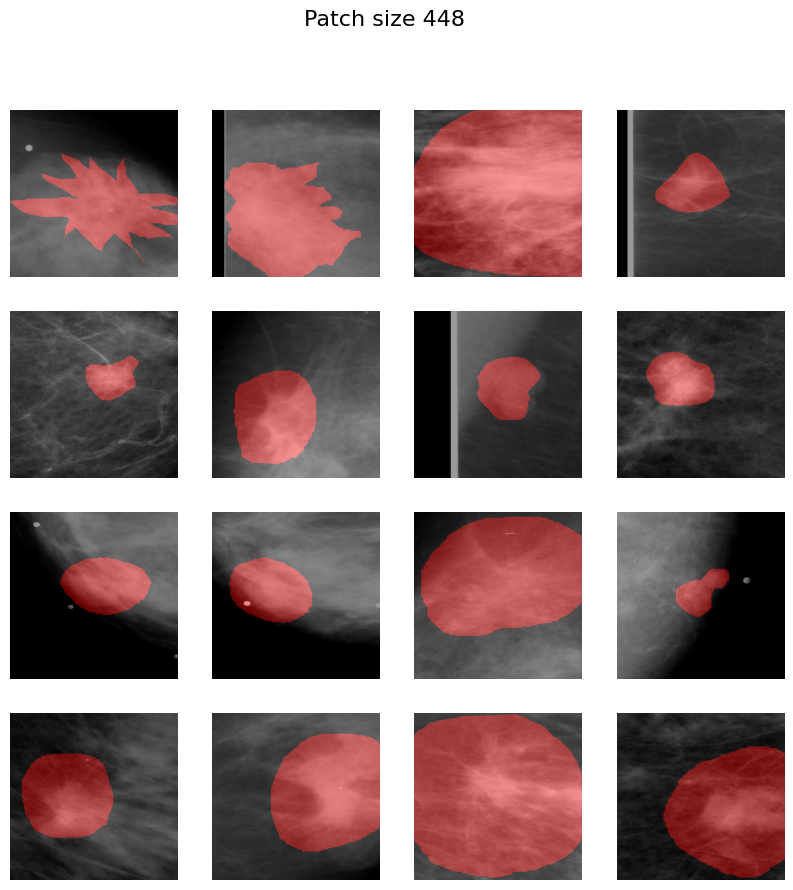

In [16]:
patch_size = 448
mass_malignat = pathlib.Path(f'/tmp/eval_patches_16bits_{patch_size}_x2_test_nikulin/malignant_mass/')

images = list(mass_malignat.glob('*img.npy'))

#sample 16 images
nrow = 4
ncol = 4
num_images = nrow * ncol

images = np.random.choice(images, num_images)
masks = [str(img).replace('_img.png', '_mask.png') for img in images]
masks = [str(img).replace('_img.npy', '_mask.png') for img in images]

print("Num images: ", len(images), len(masks))

fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(10, 10))
ax = ax.ravel()




for i in range(num_images):
    if images[i].suffix == '.npy':
        img = np.load(images[i])
    else:
        img = np.array(Image.open(images[i]))
    assert img.shape[0] == img.shape[1] and img.shape[0] == patch_size, f"{img.shape}"
    mask = np.array(Image.open(masks[i]))
    show_mask_image(img, mask, ax[i])

# set figure title
fig.suptitle(f"Patch size {patch_size}", fontsize=16)



In [ ]:
patch_size = 448
background = pathlib.Path(f'/tmp/eval_patches_16bits_{patch_size}_test_nikulin/background')

images = list(background.glob('*img.npy'))

print("Number of images: ", len(images), background)

#sample 16 images
nrow = 4
ncol = 4
num_images = nrow * ncol

images = np.random.choice(images, num_images)
masks = [str(img).replace('_img.npy', '_mask.png') for img in images]
print("Num images: ", len(images), len(masks))

fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(10, 10))
ax = ax.ravel()



for i in range(num_images):
    #img = np.array(Image.open(images[i]))
    img = np.load(images[i])
    mask = np.array(Image.open(masks[i]))
    mask = None
    show_mask_image(img, mask, ax[i])


Number of images:  0 /tmp/eval_patches_16bits_448_test_nikulin/background


ValueError: 'a' cannot be empty unless no samples are taken

: 

# Hard negatives

In [14]:


patch_size = 448
def extract_hard_negatives_from_anot(annotation,test_images, out_dir, ddsm_root_dir,  neg_cutoff=0.2, nb_bkg=2, 
                                    patch_size=448):
    ddsm_root_dir = pathlib.Path(ddsm_root_dir)
    
    image_id = annotation['image_id']
    
    if image_id not in test_images:
        return

    
    image_path = ddsm_root_dir / image_id
    img = np.array(Image.open(str(image_path)))
    
    mask_id = annotation['mask_id']
    roi_mask_path = ddsm_root_dir / mask_id
    roi_mask = np.array(Image.open(str(roi_mask_path)))
    
    
    points = np.array(annotation['outline']).T
    
    xmin, ymin = points.min(axis=0)
    xmax, ymax = points.max(axis=0)
    xmin = max(xmin, 0)
    ymin = max(ymin, 0)
    xmax = min(xmax, img.shape[1]-1)
    ymax = min(ymax, img.shape[0]-1)
    
    width = xmax - xmin
    height = ymax - ymin
    bounding_box = (xmin, ymin, width, height)
    
    sample_hard_negatives(img, roi_mask, out_dir, mask_id, bounding_box, patch_size=patch_size,
                neg_cutoff=neg_cutoff,
                nb_bkg=nb_bkg, 
                verbose=False)


In [15]:
!rm /tmp/eval_patches_hardneg_* -rf
root_ddsm = pathlib.Path('/home/alalbiol/Data/mamo/DDSM_png_16bit_1152x896')


test_images = pd.read_csv(split_csv)
test_images = test_images.ddsm_image.values
print("num test images: ", len(test_images))


patch_sizes = [448]

for patch_size in patch_sizes:
    print(f"Extractig patches of size {patch_size}")
    out_dir = pathlib.Path(f'/tmp/eval_patches_hardneg_{patch_size}_test_nikulin/')

    out_dir.mkdir(exist_ok=True)


    for k in tqdm(range(len(annotations))):
        extract_hard_negatives_from_anot(annotations.iloc[k],test_images, out_dir, 
                                        ddsm_root_dir, patch_size=patch_size, neg_cutoff=0.2, nb_bkg=2)
        

num test images:  986
Extractig patches of size 448


100%|██████████| 4664/4664 [00:53<00:00, 87.50it/s] 


Num images:  746
Num images:  16 16


Text(0.5, 0.98, 'Hard negatives Patch size 448')

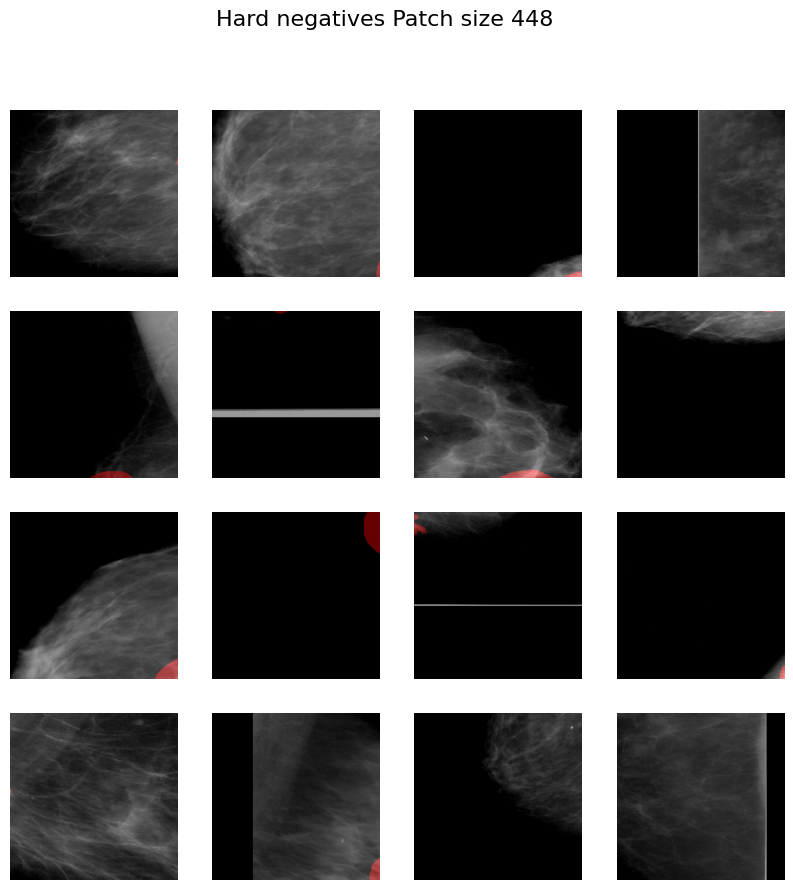

: 

In [ ]:
patch_size = 448
background = pathlib.Path(f'/tmp/eval_patches_hardneg_{patch_size}_test_nikulin/background/')

images = list(background.glob('*img.png'))

print("Num images: ", len(images))

#sample 16 images
nrow = 4
ncol = 4
num_images = nrow * ncol

images = np.random.choice(images, num_images)
masks = [str(img).replace('_img.png', '_mask.png') for img in images]
print("Num images: ", len(images), len(masks))

fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(10, 10))
ax = ax.ravel()



for i in range(num_images):
    img = np.array(Image.open(images[i]))
    mask = np.array(Image.open(masks[i]))
    assert img.shape[0] == img.shape[1] and img.shape[0] == patch_size, f"{img.shape}"
    show_mask_image(img, mask, ax[i])

fig.suptitle(f"Hard negatives Patch size {patch_size}", fontsize=16)


# Test patch extractor at blobs



In [ ]:

import cv2

def extract_negatives_from_blobs(image_path, out_dir, neg_cutoff=0.2, nb_bkg=50, patch_size=256):
        
    img = np.array(Image.open(str(image_path)))
    
    roi_mask = np.zeros_like(img, dtype=np.uint8) 
    
    
    
    img_id = image_path.name
    
    blob_min_area=3 
    blob_min_int=.5
    blob_max_int=.85
    blob_th_step=10
    
    roi_size = (256, 256)
    
        # Build a blob detector.
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minArea = blob_min_area
    params.maxArea = roi_size[0]*roi_size[1]
    params.filterByCircularity = False
    params.filterByColor = False
    params.filterByConvexity = False
    params.filterByInertia = False
    # blob detection only works with "uint8" images.
    params.minThreshold = int(blob_min_int*255)
    params.maxThreshold = int(blob_max_int*255)
    params.thresholdStep = blob_th_step
    # import pdb; pdb.set_trace()
    ver = (cv2.__version__).split('.')
    if int(ver[0]) < 3:
        blob_detector = cv2.SimpleBlobDetector(params)
    else:
        blob_detector = cv2.SimpleBlobDetector_create(params)


    
    sample_blob_    negatives(img, roi_mask, out_dir, img_id, 
                blob_detector, patch_size=patch_size,
                neg_cutoff=neg_cutoff,
                nb_bkg=nb_bkg, 
                verbose=False)



In [54]:

!rm /tmp/eval_patches_blobneg_* -rf

ddsm_root_dir = pathlib.Path('/home/alalbiol/Data/mamo/DDSM_png_1152x896/normals')
normal_imgs = list(ddsm_root_dir.rglob('*.png'))
print("Number of normal images: ", len(normal_imgs))

for patch_size in [512, 256, 224]:
    print(f"Extractig patches of size {patch_size}")
    out_dir = pathlib.Path(f'/tmp/eval_patches_blobneg_{patch_size}')

    out_dir.mkdir(exist_ok=True)

    for image_path in tqdm(normal_imgs):
        extract_negatives_from_blobs(image_path, out_dir, neg_cutoff=0.2, nb_bkg=10, patch_size=patch_size)



Number of normal images:  2780
Extractig patches of size 512


100%|██████████| 2780/2780 [19:46<00:00,  2.34it/s]


Extractig patches of size 256


100%|██████████| 2780/2780 [08:06<00:00,  5.72it/s]


Extractig patches of size 224


100%|██████████| 2780/2780 [06:52<00:00,  6.74it/s]


Num images:  27383
Num images:  16 16


Text(0.5, 0.98, 'Negative blob  Patch size 256')

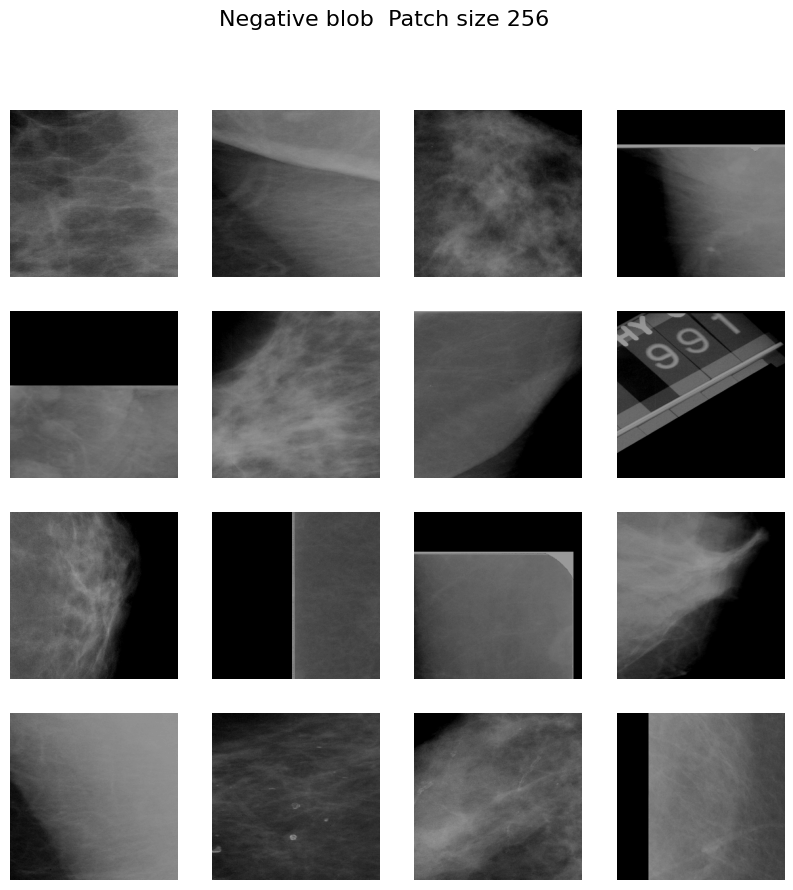

In [14]:
patch_size = 256
background = pathlib.Path(f'/tmp/eval_patches_blobneg_{patch_size}/background/')

images = list(background.glob('*img.png'))

print("Num images: ", len(images))

#sample 16 images
nrow = 4
ncol = 4
num_images = nrow * ncol

images = np.random.choice(images, num_images)
masks = [str(img).replace('_img.png', '_mask.png') for img in images]
print("Num images: ", len(images), len(masks))

fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(10, 10))
ax = ax.ravel()



for i in range(num_images):
    img = np.array(Image.open(images[i]))
    mask = np.array(Image.open(masks[i]))
    assert img.shape[0] == img.shape[1] and img.shape[0] == patch_size, f"{img.shape}"
    show_mask_image(img, mask, ax[i])

fig.suptitle(f"Negative blob  Patch size {patch_size}", fontsize=16)